In [ ]:
# upgrade scipy to be able to use qmc
# after that automatically restarts the cell
import os
! pip install scipy --upgrade
os.kill(os.getpid(), 9)

In [1]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

In [2]:
tf.keras.backend.set_floatx("float64")

[3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265]


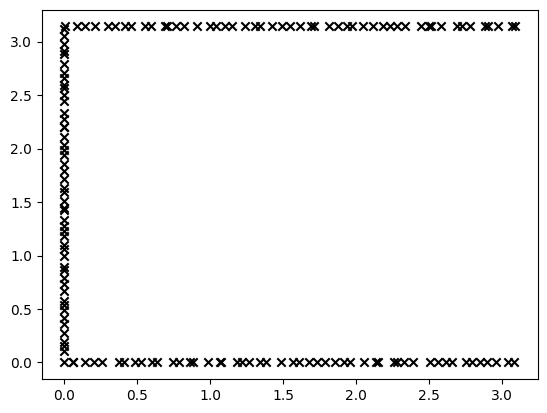

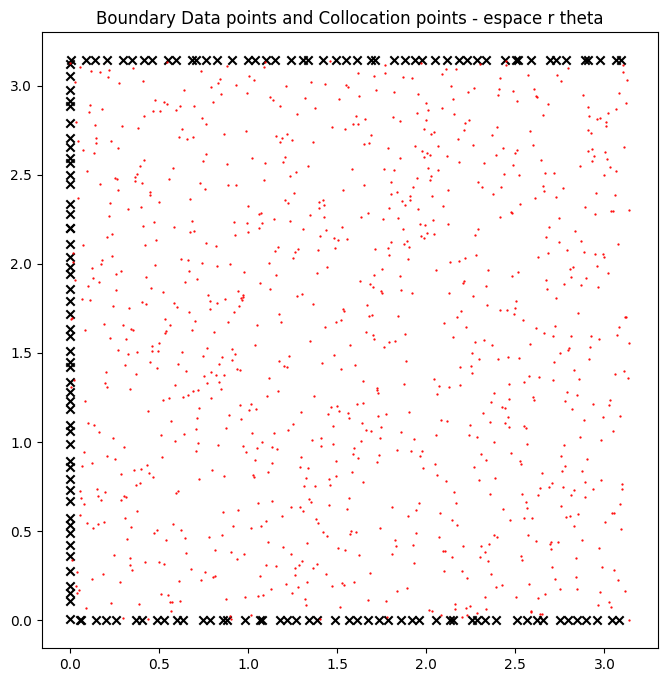

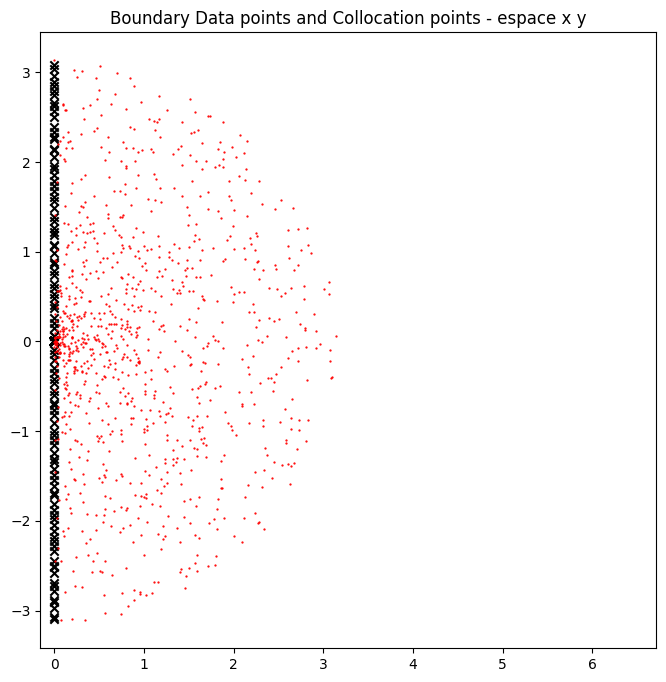

In [3]:
# Version solving in r, theta .......................
# the first index is r, the secong being theta ........
# The derivatives can be also imposed on the boundaries
#....................................................

### data generation on boundary (at r = 0).......
rmax= np.pi 
n_bc = 3
n_data_per_bc = 50

# Define the datapoints locations in (r, theta) space ...
# r vary between 0 and rmax, theta between 0 and 2pi .....
engine = qmc.LatinHypercube(d=1)
data = np.zeros([n_bc ,n_data_per_bc , 5])

for i, j in zip(range(n_bc), [0., 1., 0, 1.]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.) * 1
    #points = np.linspace(0, +1, n_data_per_bc)
    
    if i < 1:
        data[i, :, 0] = j + 0.
        data[i, :, 1] = points - 0.
    else:
        data[i, :, 0] = points + 0.
        data[i, :, 1] = j -0.

data[:, :, 0] = rmax * data[:, :, 0] - 0
data[:, :, 1] = np.pi*data[:, :, 1] 

print(data[1, : , 1])

fac=1
# Values of data , derivative/r , and derivative/theta ...
for j in range(0,n_data_per_bc):    
    # ...........................     
    data[0, j, 2] = 1
    data[0, j, 3] = 0
    data[0, j, 4] = 0

    data[1,j,2] = np.sin(fac*data[1,j,0])/data[1,j,0]/fac 
    data[1,j,3] = 0
    data[1,j,4] = 0.
    data[2,j,2] = np.sin(fac*data[2,j,0])/data[2,j,0]/fac
    data[2,j,3] = 0
    data[2,j,4] = 0.

data = data.reshape(n_data_per_bc * n_bc, 5)

# t_d are data values, t_dx and td_y derivatives wrt r and mu respectively .....
x_d, y_d, t_d, t_dx, t_dy = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4]])

plt.scatter(data[:,0], data[:,1], marker="x", c="k", label="BDP")
plt.show()

# in order to see other vosualization of the points .......
theta = data[:, 1] 
xda = data[:,0] * np.sin(theta)
yda = data[:,0] * np.cos(theta)


# collocation points .................
Nc = 1000
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 1 * (colloc -0)

#
colloc[:, 0] = rmax*colloc[:, 0]
colloc[:, 1] = np.pi*colloc[:, 1]

# in order to see other visualization of the points ...........
thetad = colloc[:, 1]
xdad = colloc[:,0] * np.sin(thetad)
ydad = colloc[:,0] * np.cos(thetad)

#
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])
#


plt.figure("", figsize=(8, 8))
plt.title("Boundary Data points and Collocation points - espace r theta")
plt.scatter(data[:,0], data[:,1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:,0], colloc[:,1], s=1.5, marker=".", c="r", label="CP")
plt.axis("square")
plt.show()


plt.figure("", figsize=(8, 8))
plt.title("Boundary Data points and Collocation points - espace x y")
plt.scatter(xda, yda, marker="x", c="k", label="BDP")
plt.scatter(xdad, ydad, s=1.5, marker=".", c="r", label="CP")
plt.axis("square")
plt.show()
    
#
#

x_c, y_c, x_d, y_d, t_d, t_dx, t_dy = map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
                             [x_c, y_c, x_d, y_d, t_d, t_dx, t_dy])

In [4]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=5, 
                neuron_per_layer=30, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [5]:
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 5, 30, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

Model: "DNN-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 30)                90        
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 30)                930       
                                                                 
 dense_5 (Dense)             (None, 1)                 31    

In [6]:
@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u

@tf.function
def uderx(x, y):
    u = model(tf.concat([x, y], axis=1))
    uderx = tf.gradients(u, x)[0]
    return uderx

@tf.function
def udery(x, y):
    u = model(tf.concat([x, y], axis=1))
    udery = tf.gradients(u,y)[0]
    return udery



In [7]:
@tf.function
def f(x, y):
    u0 = u(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    

    # The residual with x being r and y being theta ....
    # KK = 0 is a case without rotation
    #....................................
    KK = 0.  
    indic=1
    
    F = x*x*u_xx + 2*x*u_x + u_yy +u_y/tf.math.tan(y) + x*x*u0**indic - x*x*KK 
    
    retour = tf.reduce_mean(tf.square(F)) 
    return retour



In [8]:
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

@tf.function
def mseinv(y, y_):
    return tf.reduce_mean(1/tf.square(y-y_))

@tf.function
def msex(y, y_):
    # MSE only for the boundary at x = 0 .....
    yr = tf.reshape(y,[n_bc, n_data_per_bc])
    yr_= tf.reshape(y_,[n_bc, n_data_per_bc])
    yrr = yr[0:1,:]
    yrr_= yr_[0:1,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour

@tf.function
def msey(y, y_):
    # MSE only for the 2 boundaries at y = .......
    yr = tf.reshape(y,[n_bc, n_data_per_bc])
    yr_= tf.reshape(y_,[n_bc, n_data_per_bc])
    yrr = yr[1:3,:]
    yrr_= yr_[1:3,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour



    0, 474.999182149
  100, 0.988331902
  200, 0.856170675
  300, 0.733227903
  400, 0.620414972
  500, 0.522971014
  600, 0.442621945
  700, 0.378417970
  800, 0.327904314
  900, 0.288007904
 1000, 0.255737846
 1100, 0.228653766
 1200, 0.205053598
 1300, 0.183923865
 1400, 0.164763531
 1500, 0.147387979
 1600, 0.131771694
 1700, 0.117942371
 1800, 0.105916469
 1900, 0.095663109
 2000, 0.087088288
 2100, 0.080035660
 2200, 0.074300815
 2300, 0.069654145
 2400, 0.065865776
 2500, 0.062726485
 2600, 0.060060858
 2700, 0.057731990
 2800, 0.055639417
 2900, 0.053713056
 3000, 0.051905800
 3100, 0.050186634
 3200, 0.048535172
 3300, 0.046937809
 3400, 0.045385231
 3500, 0.043870913
 3600, 0.042390236
 3700, 0.040939934
 3800, 0.039517736
 3900, 0.038122074
 4000, 0.036751856
 4100, 0.035406269
 4200, 0.034084621
 4300, 0.032786233
 4400, 0.031510355
 4500, 0.030256127
 4600, 0.029022563
 4700, 0.027808564
 4800, 0.026612946
 4900, 0.025434479
 5000, 0.024271942
 5100, 0.023124186
 5200, 0.0

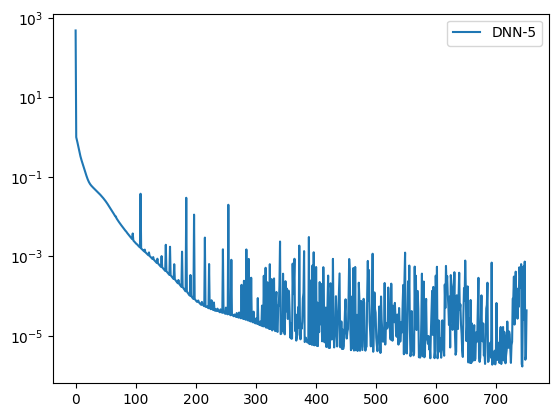

In [9]:
loss = 0
epochs = 75000
opt = tf.keras.optimizers.legacy.Adam(learning_rate=3e-4)
epoch = 0
loss_values = np.array([])
L_values = np.array([])
l_values = np.array([])

#
start = time.time()
#
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_ = u(x_d, y_d)
        Tderx_= uderx(x_d, y_d)
        Tdery_ = udery(x_d, y_d)

        # Loss on PDE
        L = 1*f(x_c, y_c) 
                       
        #l = Loss on BCs (see paper)        
        l = msex(t_d, T_) + 0*msey(t_d  , T_)        
        l = l + msex(t_dx, Tderx_) +1* msey(t_dy, Tdery_)
        
        loss = L + l 
        
    g = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    #loss_values = np.append(loss_values, loss)
    #L_values = np.append(L_values, L)
    #l_values = np.append(l_values, l)

    
    if epoch % 100 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss.numpy():.9f}")
        loss_values = np.append(loss_values, loss)
        L_values = np.append(L_values, L)
        l_values = np.append(l_values, l)

#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
plt.semilogy(loss_values, label=model.name)
plt.legend()

In [10]:
# for visualization of the predicted results
n = 200
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])


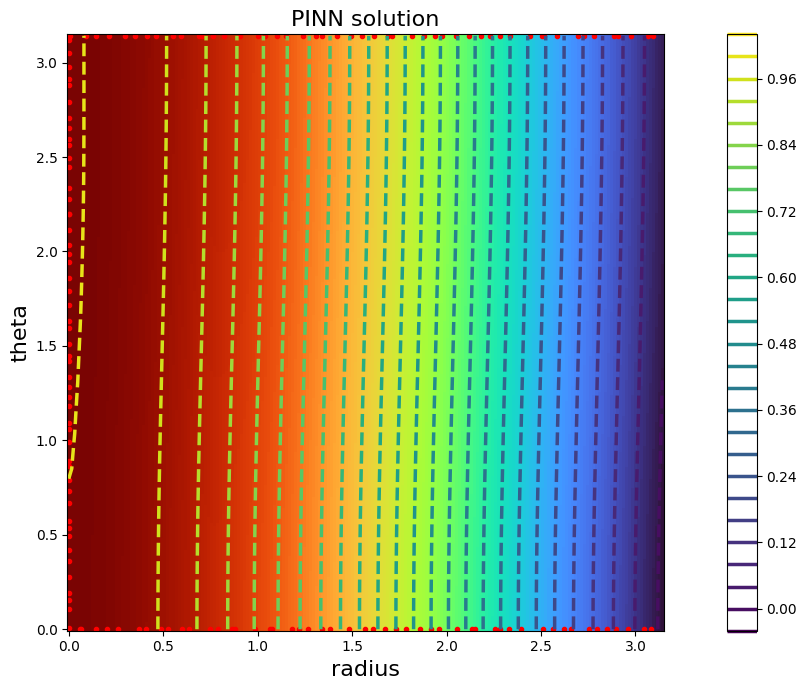

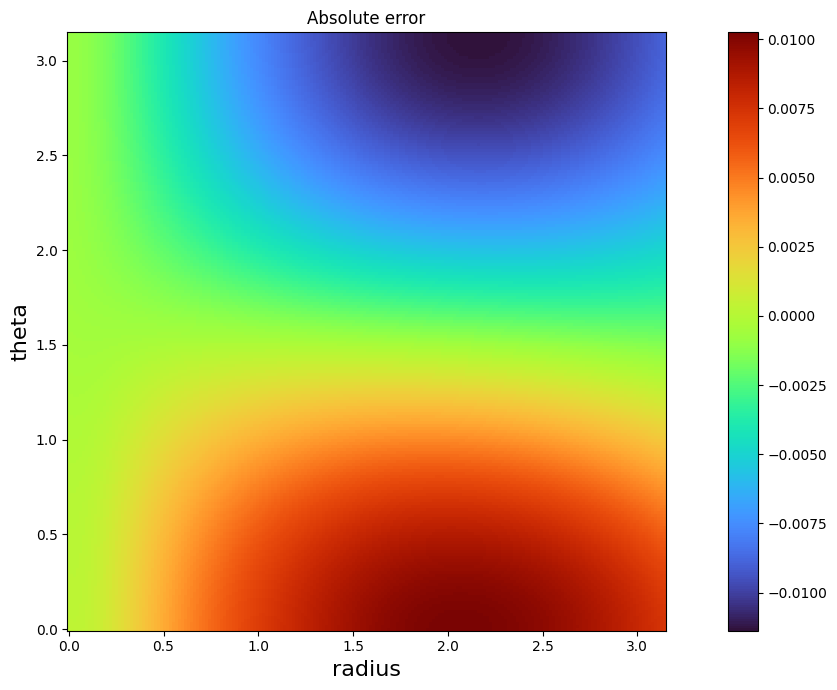

/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_3633/3797156684.py:69: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(nx, ny, S2, cmap="turbo")


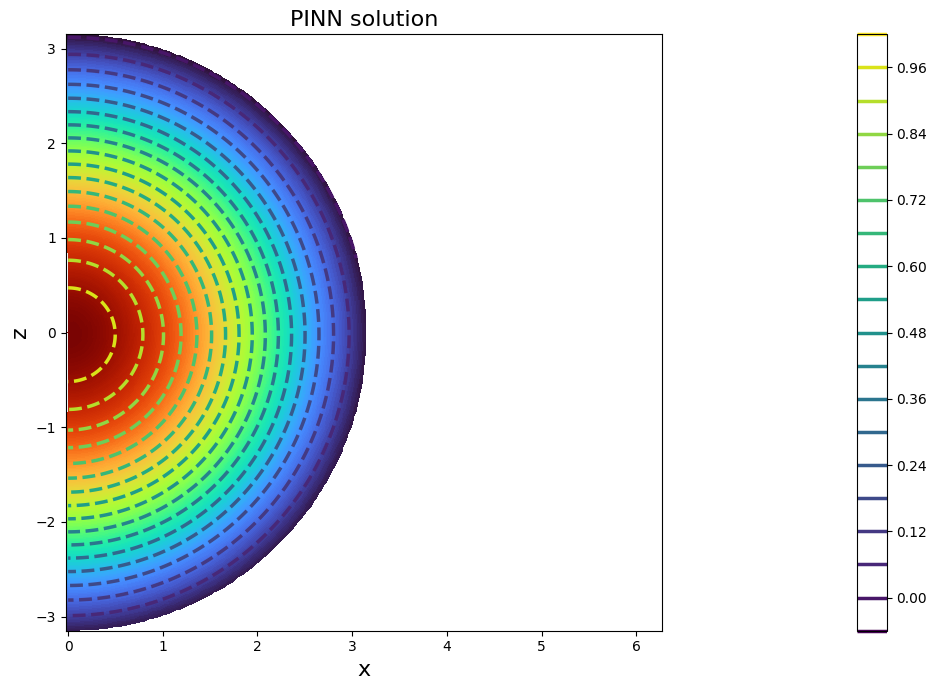

In [11]:
### plotting
#plt.figure("", figsize=(16, 8))
plt.figure("", figsize=(14, 7))
#
lim1=np.pi
lim2=rmax

X = np.linspace(0.000, lim2, n)
Y = np.linspace(0, lim1, n)
X0, Y0 = np.meshgrid(X, Y)


X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)
S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)
#

S2=S
#S2[S < 0] =  0.00000000000000000
plt.pcolormesh(X0, Y0, S2, cmap="turbo")
plt.contour(X0, Y0, S2,28,linestyles='dashed',linewidths=2.5)
plt.colorbar(pad=-0.25)
plt.scatter(data[:, 0], data[:, 1], marker=".", c="r", label="BDP")
#plt.scatter(colloc[:,0], colloc[:,1], marker=".", c="b")
plt.xlabel("radius",fontsize=16)
plt.ylabel("theta",fontsize=16)
plt.xlim(0, lim2)
plt.ylim(0, lim1)
plt.title("PINN solution",fontsize=16)
plt.tight_layout()
plt.axis("square")

plt.show()
#

plt.figure("", figsize=(14, 7))
# true sol for indice = 1
TT = np.sin(X0+1e-10)/(X0+1e-10)
# true sol for indic = 5
#TT = 1/np.sqrt(1+X0**2/3)
# true sol for indic = 0
#TT = 1-X0**2/6

TT2 = TT -S2

#TT2[TT2 < 0] = -0.00000000000000000
#err=(TT2-S2)**2/1**2
plt.pcolormesh(X0, Y0, TT2, cmap="turbo")
#plt.contour(X0, Y0, TT2,21)
plt.colorbar(pad=-0.25)
plt.xlabel("radius",fontsize=16)
plt.ylabel("theta",fontsize=16)
plt.xlim(0, lim2)
plt.ylim(0, lim1)
plt.title("Absolute error")
plt.tight_layout()
plt.axis("square")

plt.show()
#

ny = X0*np.cos(Y0)
nx = X0*np.sin(Y0)

plt.figure("", figsize=(14, 7))
plt.pcolormesh(nx, ny, S2, cmap="turbo")
plt.contour(nx, ny, S2,18,linestyles='dashed',linewidths=2.5)
plt.colorbar(pad=-0.1)
#plt.scatter(data[:, 0], data[:, 1], marker=".", c="r", label="BDP")
#plt.scatter(colloc[:,0], colloc[:,1], marker=".", c="b")
plt.xlabel("x",fontsize=16)
plt.ylabel("z",fontsize=16)
plt.xlim(0, lim2)
plt.ylim(-lim2, lim2)
plt.title("PINN solution",fontsize=16)
plt.tight_layout()
plt.axis("square")

plt.show()




[0, 49, 99, 149, 199]
[0, 49, 99, 149, 199]


/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_3633/2928793526.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_3633/2928793526.py:62: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


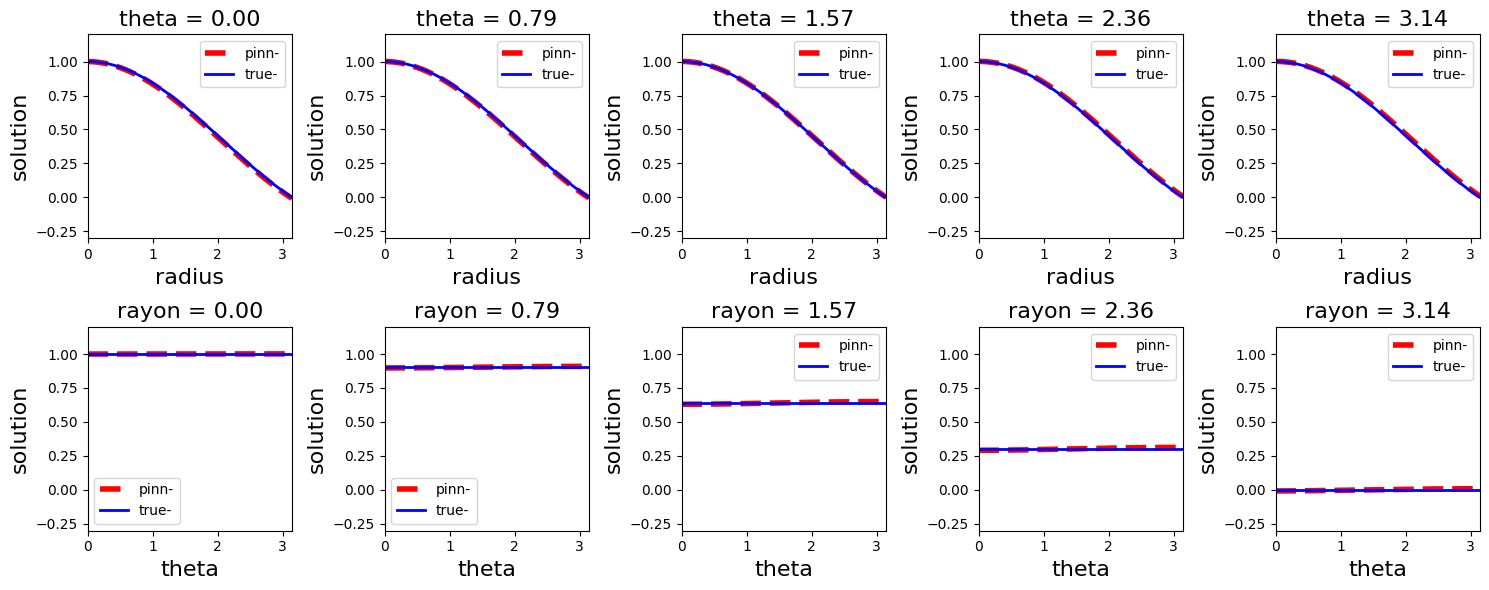

In [12]:
# To compare cuts ........ manetic field B_y ...
X = np.linspace(0, lim2, n)
Y = np.linspace(0, +lim1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)

x = np.linspace(0, lim2, n)
y = np.linspace(0, lim1, n)
x, y = np.meshgrid(x, y)


Scomp = u(X_T, Y_T)
S = Scomp
S = S.numpy().reshape(n, n)
S_ = S.reshape([n, n])
# True B_y .................
T_ = np.sin(x+1e-10)/(x + 1e-10)
#T_= 1/np.sqrt(1+x*x/3)
#T_ = 1 -x*x/6
height = 3
frames_val = np.array([0, lim1/4, lim1/2, 3*lim1/4, lim1])
#frames = [*map(int, (frames_val + 1)/2/np.pi * (n-1))]
frames = [*map(int, (frames_val + 0)/1/lim1 * (n-1))]

print (frames)

fig = plt.figure("", figsize=(len(frames)*height, 2*height))

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), i+1)
    plt.title(f"theta = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(X0[var_index, :], S_[var_index,:], "r--", lw=4., label="pinn-")
    plt.plot(X0[var_index, :], T_[var_index,:], "b", lw=2., label="true-")
    plt.ylim(-0.3, 1.2)
    plt.xlim(0, lim2)
    plt.xlabel("radius",fontsize=16)
    plt.ylabel("solution",fontsize=16)
    plt.tight_layout()
    plt.legend()

#print(Y0.shape)

height = 3
frames_val = np.array([0, rmax/4, rmax/2, 3*rmax/4, rmax])
#frames = [*map(int, (frames_val + 1)/rmax/2 * (n-1))]
frames = [*map(int, (frames_val + 0)/1/rmax * (n-1))]

print(frames)

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), len(frames) + i+1)
    plt.title(f"rayon = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(Y0[:, var_index], S_[:,var_index], "r--", lw=4., label="pinn-")
    plt.plot(Y0[:, var_index], T_[:,var_index], "b", lw=2., label="true-")
    plt.ylim(-0.3, 1.2)
    plt.xlim(0, lim1)
    plt.xlabel("theta",fontsize=16)
    plt.ylabel("solution",fontsize=16)
    plt.tight_layout()
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


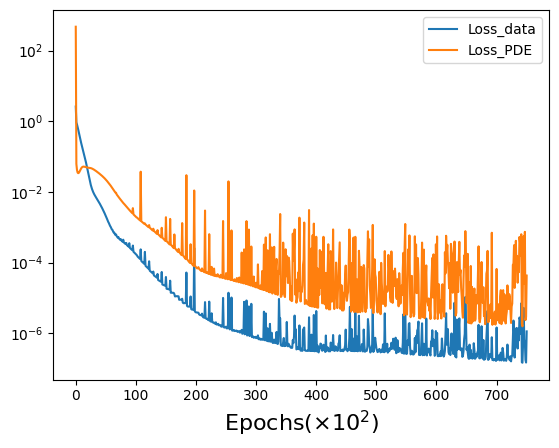

In [13]:
plt.legend()
plt.semilogy(l_values, label='Loss_data')
plt.legend()

plt.semilogy(L_values, label='Loss_PDE')
plt.xlabel("Epochs" r'($\times 10^2$)',fontsize=16)
plt.legend()